# [Tree-based Models in Python](https://www.datacamp.com/completed/statement-of-accomplishment/course/139ce5b390a8d8c6aff4bf1fc2d8eeb099c2d5c8)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/tree_models_in_python/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/tree_models_in_python/notebook.ipynb)

**Contents**
- [Data](#Data)
- [Classification and Regression Trees](#Classification-and-Regression-Trees)
- [Bias-Variance Tradeoff](#Bias-Variance-Tradeoff)
- [Parallel Ensembles](#Parallel-Ensembles)
- [Boosting](#Boosting)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)


## Data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingClassifier,
)
from sklearn.exceptions import FitFailedWarning
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings(
    "ignore",
    category=FitFailedWarning,
    module="sklearn.model_selection",
)  # final exercise


### Auto MPG

In [2]:
# https://archive.ics.uci.edu/dataset/9/auto+mpg
auto_mpg = fetch_ucirepo(id=9)
auto_df = auto_mpg.data.original

# drop `car_name` column
auto_df = auto_df.drop("car_name", axis=1)

# drop missing `horsepower` rows
auto_df = auto_df.dropna(subset=["horsepower"])

# one-hot encode `origin` column
auto_df = pd.get_dummies(
    auto_df,
    columns=["origin"],
    dtype="int8",
)
auto_df = auto_df.rename(
    columns={
        "origin_1": "origin_us",
        "origin_2": "origin_europe",
        "origin_3": "origin_asia",
    }
)

# display
display(auto_df.sample(5, random_state=42))


,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg,origin_us,origin_europe,origin_asia
79,4,96.0,69.0,2189,18.0,72,26.0,0,1,0
276,4,121.0,115.0,2795,15.7,78,21.6,0,1,0
248,4,91.0,60.0,1800,16.4,78,36.1,0,0,1
56,4,91.0,70.0,1955,20.5,71,26.0,1,0,0
393,4,140.0,86.0,2790,15.6,82,27.0,1,0,0


### Breast Cancer Wisconsin (Diagnostic)

In [3]:
# https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
cancer_df = breast_cancer_wisconsin_diagnostic.data.original

# drop `ID` column
cancer_df = cancer_df.drop("ID", axis=1)

# encode `Diagnosis` column (B=benign, M=malignant)
cancer_df["Diagnosis"] = cancer_df["Diagnosis"].map({"B": 0, "M": 1})

# display
display(cancer_df.sample(5, random_state=42))


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750,0
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589,1
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019,1
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359,0
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134,0


### ILPD (Indian Liver Patient Dataset)

In [4]:
# https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset
indian_liver_patient = fetch_ucirepo(id=225)
liver_df = indian_liver_patient.data.original
liver_cat_cols = ["Male", "Patient"]
liver_num_cols = [
    "Age",
    "TB",
    "DB",
    "Alkphos",
    "Sgpt",
    "Sgot",
    "TP",
    "ALB",
    "A/G Ratio",
]

# encode `Gender` and `Selector` columns
liver_df["Male"] = liver_df["Gender"].map({"Female": 0, "Male": 1})
liver_df["Patient"] = liver_df["Selector"].map({2: 0, 1: 1})
liver_df = liver_df.drop(columns=["Gender", "Selector"], axis=1)

# impute missing `A/G Ratio` values
imputer = SimpleImputer(strategy="mean")
liver_df["A/G Ratio"] = imputer.fit_transform(liver_df[["A/G Ratio"]])

# scale every column except `Male` and `Patient`
scaler = StandardScaler()
liver_df[liver_num_cols] = scaler.fit_transform(liver_df[liver_num_cols])

# display
display(liver_df.sample(5, random_state=42))


,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Male,Patient
355,-1.591632,-0.306051,-0.244506,-0.463793,-0.371107,-0.290680,1.398600,1.834526,1.109099,1,0
407,-2.024373,-0.370523,-0.458327,1.765025,0.418091,-0.006619,0.660946,0.702217,0.166351,1,1
90,0.942997,0.387029,0.468230,-0.315480,1.815630,2.563784,0.753153,0.073157,-0.524997,1,1
402,-0.169767,-0.451114,-0.493964,-0.529710,0.407130,-0.006619,1.490806,1.079653,-0.147898,0,1
268,-0.293407,1.805424,1.751155,0.277773,-0.168327,-0.120936,-0.722154,-1.310776,-1.404895,1,1


### Bike Sharing Demand

In [5]:
# https://www.kaggle.com/c/bike-sharing-demand
bikes_df = pd.read_csv("bike_sharing_demand.csv")
display(bikes_df.sample(5, random_state=42))


,hr,holiday,workingday,temp,hum,windspeed,instant,mnth,yr,Clear to partly cloudy,Light Precipitation,Misty,cnt
1318,22,0,1,0.70,0.61,0.0000,14322,8,1,0,0,1,251
899,11,0,1,0.76,0.66,0.0896,13903,8,1,0,0,1,214
439,7,0,1,0.74,0.58,0.2836,13443,7,1,1,0,0,473
560,8,0,1,0.74,0.70,0.1940,13564,7,1,1,0,0,743
433,1,0,1,0.74,0.66,0.0896,13437,7,1,1,0,0,25


## Classification and Regression Trees

_Classification and Regression Trees_ (CART) are a set of supervised learning models.

### Decision Trees

A _decision tree_ is a flowchat-like structure where each internal node represents a "test" on a feature (e.g., heads or tails).

The root node at the top of the tree represents the entire dataset. The choice of which feature to test is determined by criteria like _information gain_, _Gini impurity_, and _variance reduction_.

The tree is grown by partitioning the data into subsets that are as homogenous as possible. This partitioning continues until a stopping criterion is reached, like maximum tree depth, minimum samples per leaf, minimum samples required to split, etc.

**Links**
* <https://en.wikipedia.org/wiki/Decision_tree_learning>
* <https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html>
* <https://developers.google.com/machine-learning/decision-forests/decision-trees>
* <https://blog.paperspace.com/decision-trees>

**Videos**
- [@statquest: Decision and Classification Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=_L39rN6gz7Y)
- [@statquest: Regression Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=g9c66TUylZ4)

#### Classification

A _classification tree_ is a decision tree where the target variable is categorical. The leafs of the tree represent the class labels and the branches represent the conjunctions of features that lead to those class labels.

In [6]:
# train/test split
X = cancer_df.drop("Diagnosis", axis=1).values
y = cancer_df["Diagnosis"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# fit and predict
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {acc:.2f}")


Decision Tree Accuracy: 0.94


#### Regression

A _regression tree_ is a decision tree where the target variable is continuous. Unlike in a classification tree, the prediction for a regression tree is the average of the observations in the leaf that the observation you're trying to predict belongs to. Like a classification tree, the depth is limited by a stopping criterion.

In [7]:
# train/test split
X = auto_df.drop("mpg", axis=1).values
y = auto_df["mpg"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# fit decision tree regressor
dt = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=0.13,
    random_state=42,
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred)
rmse_dt = mse_dt ** (1 / 2)

# fit linear regressor
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** (1 / 2)

print("Linear Regression RMSE: {:.2f}".format(rmse_lr))  # 3.26
print("Regression Tree RMSE: {:.2f}".format(rmse_dt))  # 3.97


Linear Regression RMSE: 3.26
Regression Tree RMSE: 3.97


## Bias-Variance Tradeoff

The _Bias-Variance Tradeoff_ is a fundamental concept in machine learning that describes the balance between the two sources of error in a model: _bias_ and _variance_.

Bias is introduced when a model makes overly simplistic assumptions about the data. High bias leads to missing relationships between features and the target output, which is known as _underfitting_.

Variance is when there is too much complexity in the learning algorithm. High variance leads to the model learning noise from the training data, which then leads to poor predictions on data it hasn't seen before. This means the model is not able to "generalize" well, which is known as _overfitting_.

Linear models, due to their simplicity and the assumption of a linear relationship between the features and the target, typically exhibit high bias and low variance. This simplicity makes them less sensitive to noise, hence the low variance.

Tree-based models often have low bias and high variance. They can capture more complex patterns and interactions between variables, making them more adaptable to the data (low bias). However, this also makes them more sensitive to noise (high variance).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)

dt = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=0.26,
    random_state=42,
)

# 10-folds cross-validation negative MSE
MSE_CV_scores = -cross_val_score(
    dt,
    X_train,
    y_train,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

# 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean()) ** (1 / 2)
print(f"CV RMSE: {RMSE_CV:.2f}")


CV RMSE: 4.68


In [9]:
dt.fit(X_train, y_train)

# predict training set labels
y_pred = dt.predict(X_train)

# evaluate training set RMSE
rmse = mean_squared_error(y_train, y_pred) ** (1 / 2)
print(f"Train RMSE: {rmse:.2f}")


Train RMSE: 4.29


### Ensemble Learning

_Ensemble learning_ is a technique where multiple models, often called "weak learners", are trained to solve the same problem. The predictions of the weak learners are then combined to produce a single prediction.

The idea is that multiple weak learners can together form more reliable predictions than any individual model.

Ensemble algorithms are known as _meta-models_ because they act as wrappers around other models. For example, a _Voting Classifier_ is not a model itself. The models it wraps are known as _estimators_.

#### Voting Classifiers

In voting ensembles, multiple models are trained separately and their predictions are combined by taking the majority vote (for classification) or average (for regression).

In [10]:
X = liver_df.drop("Patient", axis=1).values
y = liver_df["Patient"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=27)
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=42)
classifiers = [
    ("Logistic Regression", lr),
    ("K Nearest Neighbours", knn),
    ("Classification Tree", dt),
]

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy: {acc:.2f}")


Logistic Regression Accuracy: 0.76
K Nearest Neighbours Accuracy: 0.70
Classification Tree Accuracy: 0.73


In [11]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")


Voting Classifier Accuracy: 0.74


## Parallel Ensembles

_Parallel_ ensembles help with errors due to variance, that is, if your model is overfitting. They are parallel in that each learner is built independently of the others.

### Bagging

_Bagging_ means _bootstrap aggregating_. Bootstrapping is the process of taking repeated samples from a dataset (with replacement) and then training a separate model on each sample. The models are then aggregated by averaging the predictions of each model.

Bootstrapping introduces diversity into the training process, which reduces overfitting.

In [12]:
bc = BaggingClassifier(n_estimators=50, random_state=42)

bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"BaggingClassifier Accuracy: {acc:.2f}")


BaggingClassifier Accuracy: 0.76


In [13]:
bc = BaggingClassifier(
    n_estimators=50,
    oob_score=True,
    random_state=42,
)

bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
oob = bc.oob_score_
print(f"BaggingClassifier OOB Score: {oob:.2f}")


BaggingClassifier OOB Score: 0.68


### Random Forests

A _forest_ is an ensemble of _trees_. A Random Forest in particular is an ensemble of Decision Trees where each tree has been trained with bagging as well as the _random subspace method_. This technique, also known as _feature bagging_, is where each node (including root) is split on a random subset of features. This randomization introduces further diversity into the ensemble on top of bagging, which makes Random Forests even more resilient to overfitting.

**Links**
- <https://en.wikipedia.org/wiki/Random_forest>
- <https://developers.google.com/machine-learning/decision-forests/random-forests>

**Videos**
- [@statquest: Random Forests Part 1 - Building, Using and Evaluating](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)
- [@statquest: Random Forests Part 2 - Missing data and clustering](https://www.youtube.com/watch?v=sQ870aTKqiM)


In [14]:
rf = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
)

X = bikes_df.drop("cnt", axis=1).values
y = bikes_df["cnt"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred) ** (1 / 2)
print(f"RandomForestRegressor RMSE: {rmse_test:.2f}")


RandomForestRegressor RMSE: 57.44


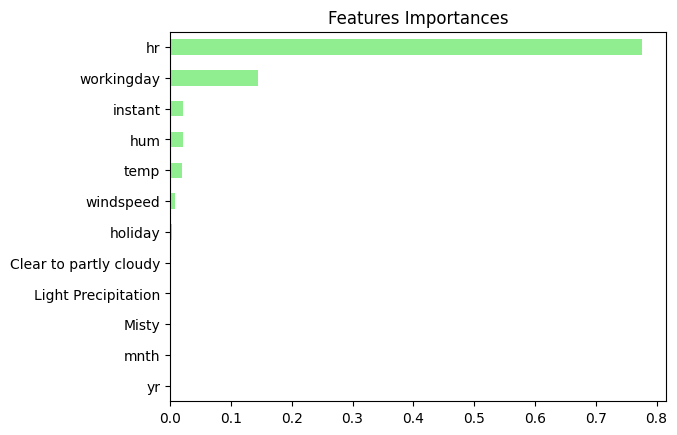

In [15]:
importances = pd.Series(
    data=rf.feature_importances_,
    index=bikes_df.drop("cnt", axis=1).columns,
)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind="barh", color="lightgreen")
plt.title("Features Importances")
plt.show()


## Boosting

While bagging and random forests train multiple learners in parallel, _boosting_ trains multiple learners in sequence. Instead of aggregating the predictions of many weak learners, boosting trains a weak learner to be a strong learner. This is done by training each learner to correct the mistakes of the previous learner.

Boosting algorithms introduce the `learning_rate` hyperparameter, which controls how much each learner corrects the mistakes of the previous learner.


### Adaptive Boosting

_Adaptive boosting_ or AdaBoost sequentially trains a series of learners. Each learner is trained on a modified version of the training set where the weights of misclassified observations are increased. This means that each learner focuses more on the observations that the previous learner got wrong. Throughout training, each learner is assigned a weight based on its accuracy. The final prediction is a weighted sum of the predictions of each learner (the ensemble).

**Links**
- <https://en.wikipedia.org/wiki/AdaBoost>
- <https://blog.paperspace.com/adaboost-optimizer>

**Videos**
- [@statquest: AdaBoost, Clearly Explained](https://www.youtube.com/watch?v=LsK-xG1cLYA)

In [16]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=180, random_state=1)

X = liver_df.drop("Patient", axis=1).values
y = liver_df["Patient"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

ada.fit(X_train, y_train)
y_pred_proba = ada.predict_proba(X_test)[:, 1]

ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {ada_roc_auc:.2f}")


ROC AUC score: 0.69


### Gradient Boosting

Learners in a _gradient boosting_ ensemble are trained sequentially, like in AdaBoost. However, instead of modifying the weights of the training set, gradient boosting uses _gradient descent_ to minimize the _loss function_ of the model.

The loss function essentially measures how wrong a model's predictions are compared to the actual values. The algorithm starts with simple initial predictions - like the average of the target values - then it calculates the residuals (the difference between the actual values and the predictions). The subsequent learners are then trained to predict the residuals of the previous learner. By making closer predictions to the actual values, the residuals are minimized (made closer to zero) and thus so is the loss function.

When making predictions, the output of the ensemble is the sum of the initial predictions and the predictions of each learner weighted by the learning rate. If you have a low learning rate, then the ensemble will have to train more learners to make accurate predictions.

For classification problems, the final prediction is the sum of the initial predictions and the predictions of each learner weighted by the learning rate. The final prediction is then converted to a probability using the _sigmoid function_ for binary classification or the _softmax function_ for multiclass classification.

For regression problems, the final prediction is the sum of the initial predictions and the predictions of each learner weighted by the learning rate (no activation function is used).

**Links**
- <https://en.wikipedia.org/wiki/Gradient_boosting>

**Videos**
- [@statquest: Gradient Boost Part 1 (of 4): Regression Main Ideas](https://www.youtube.com/watch?v=3CC4N4z3GJc)
- [@statquest: Gradient Boost Part 2 (of 4): Regression Details](https://www.youtube.com/watch?v=2xudPOBz-vs)
- [@statquest: Gradient Boost Part 3 (of 4): Classification](https://www.youtube.com/watch?v=jxuNLH5dXCs)
- [@statquest: Gradient Boost Part 4 (of 4): Classification Details](https://www.youtube.com/watch?v=StWY5QWMXCw)


In [17]:
gb = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    random_state=2,
)

X = bikes_df.drop("cnt", axis=1).values
y = bikes_df["cnt"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mse_test ** (1 / 2)
print(f"GradientBoostingRegressor RMSE: {rmse_test:.2f}")


GradientBoostingRegressor RMSE: 51.56


### Stochastic Gradient Boosting

_Stochastic gradient boosting_ or SGB is a variant of gradient boosting that introduces randomness into the training process, much like random forests.

In SGB, each learner (tree) is trained on a random subset of the training data. The `subsample` hyperparameter controls the size of the subset. The `max_features` hyperparameter controls the number of features to consider when splitting a node.

In [18]:
sgbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=4,
    subsample=0.9,
    max_features=0.75,
    n_estimators=200,
    random_state=42,
)

X = bikes_df.drop("cnt", axis=1).values
y = bikes_df["cnt"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

sgbr.fit(X_train, y_train)
y_pred = sgbr.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mse_test ** (1 / 2)
print(f"SGDRegressor RMSE: {rmse_test:.2f}")


SGDRegressor RMSE: 52.07


## Hyperparameter Tuning

**Articles**
- <https://en.wikipedia.org/wiki/Hyperparameter_optimization>
- <https://wandb.ai/site/articles/intro-to-mlops-hyperparameter-tuning>
- <https://scikit-learn.org/stable/modules/grid_search.html>

### GridSearchCV

_Grid search cross-validation_ (GridSearchCV) is a method of hyperparameter tuning that uses a grid (matrix) of hyperparameter values to train and evaluate a model.

In [19]:
X = liver_df.drop("Patient", axis=1).values
y = liver_df["Patient"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    "max_depth": [2, 3, 4],
    "min_samples_leaf": [0.12, 0.14, 0.16, 0.18],
}
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=params_dt,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)
grid_dt.fit(X_train, y_train)
best_model = grid_dt.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovo")
print(f"ROC AUC: {test_roc_auc:.2f}")


ROC AUC: 0.73


In [20]:
X = bikes_df.drop("cnt", axis=1).values
y = bikes_df["cnt"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

params_rf = {
    "n_estimators": [100, 350, 500],
    "max_features": ["log2", "auto", "sqrt"],
    "min_samples_leaf": [2, 10, 30],
}

rf = RandomForestRegressor(n_estimators=25, random_state=42)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
)
grid_rf.fit(X_train, y_train)

best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred) ** (1 / 2)
print(f"RMSE: {rmse_test:.2f}")


RMSE: 84.54
